In [1]:
%%capture
from pathlib import Path
import pandas as pd
import numpy as np
from datasets import Dataset
import seaborn as sns
from scipy import spatial

!pip install SentencePiece


## Load and prepare the dataframe

In [2]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts_clean'

In [3]:
summaries_df = pd.read_csv(SUMM_FOLDER / 'final_summaries_ai_aloe_fixed.csv', index_col=False)

In [4]:
df = summaries_df[['text', 'source', 'Main.Point', 'Details']]
ds = Dataset.from_pandas(df.reset_index(drop=True))
print(len(df))

4690


## Run the transformer

In [5]:
from transformers import AutoModel, AutoTokenizer, BigBirdTokenizer, DataCollatorWithPadding
from transformers import LongformerTokenizer

import torch

seed = 42
model_name = "allenai/longformer-base-4096" #"google/bigbird-roberta-base"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(DEVICE)
tokenizer = LongformerTokenizer.from_pretrained(model_name, use_fast=True)



Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Check the device
DEVICE

device(type='cuda')

### Run the transformer operation in cuda, then detach results and compare to make list of cos similarities

In [7]:
def getLastState(text):
    tokenized_text = tokenizer(text, return_tensors='pt').to(DEVICE)
    outputs = model(**tokenized_text)
    return outputs.last_hidden_state[0][0]

cos_similarities = []
counter = 0
for row in df.iterrows():
    print(counter, end='\r')
    text = row[1]['text']
    source = row[1]['source']
    text_embedding = getLastState(text).cpu().detach().numpy()
    source_embedding = getLastState(source).cpu().detach().numpy()
    cos_similarities.append(1 - spatial.distance.cosine(text_embedding, source_embedding))
    counter += 1

### Attach the list to the dataframe

In [8]:
df['cos_similarity'] = cos_similarities
df

/tmp/ipykernel_1596/1001860385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cos_similarity'] = cos_similarities


,text,source,Main.Point,Details,cos_similarity
0,hard work pays off / / \n,\nCivil service offers jobs to thousands of me...,0.5,0.5,0.993066
1,There will be a more petroleum product coming...,\nGasoline prices are getting higher and highe...,0.5,0.5,0.987460
2,Males have one Y chromosome and one X chromoso...,Mode of Inheritance: Sex Determination\nRecall...,1.0,2.0,0.996559
3,Electromagnetic radiation with an energy and s...,Ultraviolet radiation\n\nUltraviolet radiation...,2.5,2.0,0.990732
4,It is highly recommended by doctors that peopl...,Research indicates that sufficient amounts of ...,2.5,2.0,0.991904
...,...,...,...,...,...
4685,The results from many studies indicate that vi...,Research indicates that sufficient amounts of ...,2.5,2.0,0.996139
4686,People are being advised to spend less time in...,The sun counteracts cancer\n\nSunrays that hit...,2.5,2.0,0.996726
4687,We are thus in a situation where people are re...,"Sunbathing causes cancer \n\nBy Alex McFadden,...",2.5,2.5,0.995225
4688,"There are two types of cancers, melanoma and b...",American Cancer Society\n\n \n\nUV radiation a...,2.5,3.0,0.992790


In [9]:
# def get_doc_embed(dataset, source=None):
#     # make sure the correct source (prompt/text) is tokenized
#     tokenization = lambda x: tokenizer(x[source], padding=True, return_tensors='pt').to(DEVICE)

#     dataset = dataset.map(tokenization, batched=True)
#     dataset = dataset.with_format('torch',
#                                   columns=['input_ids', 'attention_mask'],
#                                   device=DEVICE)
    
#     # load data efficiently
#     loader = torch.utils.data.DataLoader(dataset,
#                                          batch_size=16,
#                                          collate_fn=data_collator)
    
#     features = np.empty([0,768])
#     for batch in tqdm(loader):
#         batch = {k: v.to(DEVICE) for k, v in batch.items()}
#         with torch.no_grad():
#             cls_tok = model(batch['input_ids'],
#                             batch['attention_mask']).last_hidden_state[:,0,:]
#             features = np.vstack((features,
#                                   cls_tok.cpu().numpy()))
            
#     return features

In [10]:
# ds_sample = ds#.shuffle().select(range(100))

# prompt_embeds = get_doc_embed(ds_sample, source='prompt')
# text_embeds = get_doc_embed(ds_sample, source='text')

In [11]:
# from scipy import spatial
# cos_similarities = []
# for text_embed, prompt_embed in zip(text_embeds, prompt_embeds):
#     cos_similarities.append(1 - spatial.distance.cosine(text_embed, prompt_embed))

In [12]:
# summaries_df['cos_similarity'] = pd.Series(cos_similarities)

In [13]:
# from scipy import spatial

# def getSimilarity(df):
#     text_embedding = getLastState(ds['text']).detach().numpy()
#     prompt_embedding = getLastState(df['prompt']).detach().numpy()
#     return 1 - spatial.distance.cosine(text_embedding, prompt_embedding)

# df['cos_similarity'] = df.apply(lambda x: getSimilarity(x), axis = 1)

## Examine the Results

In [14]:
# Get number of words
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Adjust the window for cosine similarity
min_similarity = 0
max_similarity = 1
df1 = df[df['cos_similarity'] > min_similarity]
df1 = df1[df1['cos_similarity'] < max_similarity]

print('Correlation with number of words:\n', df1[['cos_similarity', 'num_words']].corr(), '\n')
print('Correlation with main point:\n', df1[['cos_similarity', 'Main.Point']].corr(), '\n')
print('Correlation with details:\n', df1[['cos_similarity', 'Details']].corr(), '\n')

Correlation with number of words:
                 cos_similarity  num_words
cos_similarity        1.000000   0.347158
num_words             0.347158   1.000000 

Correlation with main point:
                 cos_similarity  Main.Point
cos_similarity        1.000000    0.390716
Main.Point            0.390716    1.000000 

Correlation with details:
                 cos_similarity   Details
cos_similarity        1.000000  0.426577
Details               0.426577  1.000000 



/tmp/ipykernel_1596/2987149325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(lambda x: len(x.split()))


### Chart the correlation between cosine similarity and score

                cos_similarity  Main.Point
cos_similarity        1.000000    0.390716
Main.Point            0.390716    1.000000


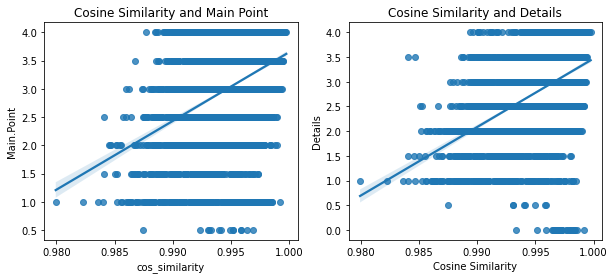

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

print(df1[df1['cos_similarity'] > 0][['cos_similarity', 'Main.Point']].corr())

fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(10)

sns.regplot(data=df1[df1['cos_similarity'] > 0], x='cos_similarity', y='Main.Point', ax = axs[0])
#plt.title('Correlation between Cosine Similarity and Main Point')
plt.ylabel('Main Point')
plt.xlabel('Cosine Similarity')
axs[0].set_title('Cosine Similarity and Main Point')

sns.regplot(data=df1, x='cos_similarity', y='Details', ax = axs[1])
#plt.title('Correlation between Cosine Similarity and Details')
plt.ylabel('Details')
plt.xlabel('Cosine Similarity')
axs[1].set_title('Cosine Similarity and Details')
plt.show()


Text(0.5, 1.0, 'Histogram of Cosine Similarity')

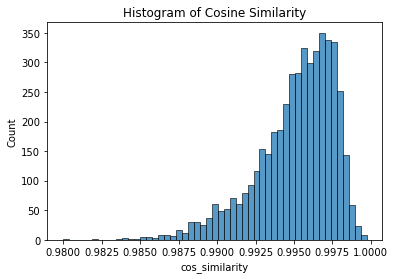

In [16]:
sns.histplot(data=df1, x='cos_similarity')
plt.title('Histogram of Cosine Similarity')

### Examine the texts themselves

In [29]:

print(len(df1))
df1_sorted = df1.sort_values(by='cos_similarity').reset_index()

i = 7

text = df1_sorted.iloc[i]['text']
sim = df1_sorted.iloc[i]['cos_similarity']
print('SUMMARY', i, '- SIMILARITY TO SOURCE:', sim, '\n' + text)

4690
SUMMARY 7 - SIMILARITY TO SOURCE: 0.9846436381340027 
American cancer society of an UV radiation cancer divide and damage. cancer types skin cancer based cell. |Uv radiation is an comman skin care statements UV occurs in the primary sun light. it is an tanning bed get an tan to the outdoor headwear UV protection direction. Offen the sun glass of the such sun glass damages accumate over the years childern

